## Walmart Sales Forecast

### 1. Understanding the problem and defining a success metric

* Data from Walmart stores accross the US is given, and it is up to us to forecast their weekly sales. 
* The data is already split into a training and a test set, and we want to fit a model to the training data that is able to forecast those weeks sales as accurately as possible. In fact, our metric of interest will be the Mean Absolute Error.

Reference: https://www.kaggle.com/fernandol/cracking-the-walmart-sales-forecasting-challenge/#data

### 2. Load and explore data

In [1]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *


#Handy for debugging
import gc
import time
import warnings
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
from imageio import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

## Keras for deep learning
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras import optimizers

## Performance measures
from sklearn.metrics import mean_squared_error

In [2]:
#Merge info
def mergeData(df):
    features =pd.read_csv('walmart/features.csv')
    storesdata =pd.read_csv('walmart/stores.csv')
    df = pd.merge(df, features, on=['Store','Date','IsHoliday'],
                  how='inner')
    df = pd.merge(df, storesdata, on=['Store'],
                  how='inner')
    return df

#http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()
def binary(movement):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    direction = np.empty(movement.shape[0])
    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

def scatterplots(feature, label):
    x = feature
    y = df['Weekly_Sales']
    plt.scatter(x, y)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

In [3]:
print('Reading data...')
print(os.listdir('walmart/'))
print(os.listdir('walmart'))

Reading data...
['features.csv', 'stores.csv', 'test.csv', 'train.csv']
['features.csv', 'stores.csv', 'test.csv', 'train.csv']


In [4]:
train = mergeData(pd.read_csv('walmart/train.csv'))
test = mergeData(pd.read_csv('walmart/test.csv'))
train['Split'] = 'Train'
test['Split'] = 'Test'
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test


In [5]:
t_len = len(train) # Get number of training examples
df = pd.concat([train,test],axis=0) # Join train and test
df.tail() # Get an overview of the data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
115059,45,93,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115060,45,94,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115061,45,95,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115062,45,97,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115063,45,98,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test


In [6]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,536634.000000,536634.000000,421570.000000,536634.000000,536634.000000,265596.000000,197685.000000,242326.000000,237143.000000,266496.000000,498472.000000,498472.000000,536634.000000
mean,22.208621,44.277301,15981.258123,58.771762,3.408310,7438.004144,3509.274827,1857.913525,3371.556866,4324.021158,172.090481,7.791888,136678.550960
std,12.790580,30.527358,22711.183519,18.678716,0.430861,9411.341379,8992.047197,11616.143274,6872.281734,13549.262124,39.542149,1.865076,61007.711799
min,1.000000,1.000000,-4988.940000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000
25%,11.000000,18.000000,2079.650000,45.250000,3.041000,2114.640000,72.500000,7.220000,336.240000,1570.112500,132.521867,6.623000,93638.000000
50%,22.000000,37.000000,7612.030000,60.060000,3.523000,5126.540000,385.310000,40.760000,1239.040000,2870.910000,182.442420,7.795000,140167.000000
75%,33.000000,74.000000,20205.852500,73.230000,3.744000,9303.850000,2392.390000,174.260000,3397.080000,5012.220000,213.748126,8.549000,202505.000000
max,45.000000,99.000000,693099.360000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000


In [7]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9

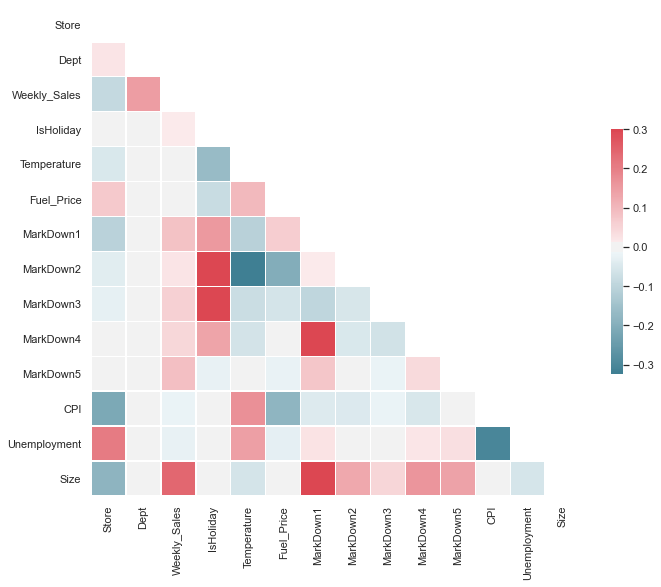

In [8]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Observations:

* Discounts are correlated and higher unemployment means lower Consumer Price Index. More interestingly, it appears that higher department numbers have higher sales. Maybe because they are newer? 
* Also, larger stores generate more sales, discounts generally generate higher sales values and larger unemployment result in a bit fewer sales. 
* Unfortunately, there appears to be little relationship between holidays, temperatures or fuelprices with our weekly sales.

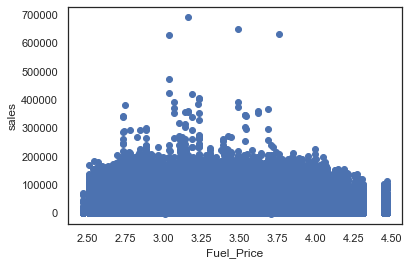

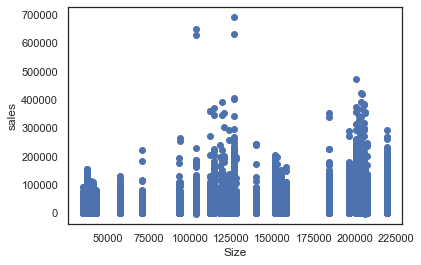

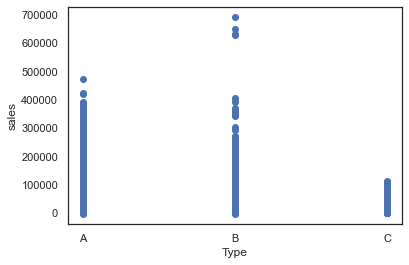

In [9]:
%matplotlib inline

headers = list(df)
labels = headers
scatterplots(df['Fuel_Price'], 'Fuel_Price')
scatterplots(df['Size'], 'Size')
#scatterplots(df['Temperature'], 'Temperature')
#scatterplots(df['Unemployment'], 'Unemployment')
#scatterplots(df['IsHoliday'], 'IsHoliday')
scatterplots(df['Type'], 'Type')

### Observations
* From the plot, it is evident that type C stores have fewer sales in general and holidays clearly show more sales.
* Although no further relationships appear evident from this analysis, there appears to be some outliers in our data. Let's take a bit of a closer look at these.

In [10]:
df.loc[df['Weekly_Sales'] >300000]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
32594,4,72,2010-11-26,381072.11,True,8.933333,2.752,NaN,NaN,NaN,NaN,NaN,126.669267,7.127,A,205863,Train
36312,4,72,2011-11-25,385051.04,True,8.866667,3.225,561.45,137.88,83340.33,44.04,9239.23,129.836400,5.143,A,205863,Train
36557,4,7,2011-12-23,318422.01,False,2.177778,3.103,2461.94,69.05,2938.24,52.00,4396.76,129.984548,5.143,A,205863,Train
51826,6,72,2010-11-26,342578.65,True,18.772222,2.735,NaN,NaN,NaN,NaN,NaN,213.267296,7.007,A,202505,Train
55545,6,72,2011-11-25,326866.60,True,17.100000,3.236,429.03,171.88,83192.81,15.00,986.23,220.041741,6.551,A,202505,Train
90645,10,72,2010-11-26,693099.36,True,12.961111,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,Train
90886,10,7,2010-12-24,406988.63,False,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,Train
90936,10,72,2010-12-24,404245.03,False,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,Train
94393,10,72,2011-11-25,630999.19,True,15.933333,3.760,174.72,329.00,141630.61,79.00,1009.98,129.836400,7.874,B,126512,Train
94634,10,7,2011-12-23,341308.00,False,9.088889,3.541,300.02,77.73,2432.01,108.37,4078.21,129.984548,7.874,B,126512,Train


### Observations
* The end of November sees a lot of exceptionally large sales. This special day, better known as Black friday, causes sales to be on fire, and undoubtedly a dummy variable should be created for this day.
* Also need to validate the data for special days like Christmas

In [11]:
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2011-08-26     1
2010-02-05     1
Name: Date, dtype: int64

## 3. Feature Engineering

### 3.1 Missing Values

In [12]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales    115064
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
Type                 0
Size                 0
Split                0
dtype: int64

In [13]:
# Create new features to indicate if the mardown was present or not
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

In [14]:
df.fillna(0, inplace=True)

#### 3.2 Feature Analysis

In [15]:
# Make sure we can later recognize what a dummy once belonged to
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [16]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

In [17]:
df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

In [18]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Split,md1_present,md2_present,md3_present,md4_present,md5_present,DateType,Month
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Type_A,151315,Train,False,False,False,False,False,2010-02-05,Month_2
1,Store_1,Dept_2,2010-02-05,50605.27,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Type_A,151315,Train,False,False,False,False,False,2010-02-05,Month_2
2,Store_1,Dept_3,2010-02-05,13740.12,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Type_A,151315,Train,False,False,False,False,False,2010-02-05,Month_2
3,Store_1,Dept_4,2010-02-05,39954.04,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Type_A,151315,Train,False,False,False,False,False,2010-02-05,Month_2
4,Store_1,Dept_5,2010-02-05,32229.38,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Type_A,151315,Train,False,False,False,False,False,2010-02-05,Month_2


In [19]:
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )

In [20]:
df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

In [21]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,DateType,Month,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
1,Store_1,Dept_2,2010-02-05,50605.27,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
2,Store_1,Dept_3,2010-02-05,13740.12,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
3,Store_1,Dept_4,2010-02-05,39954.04,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0
4,Store_1,Dept_5,2010-02-05,32229.38,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,2010-02-05,Month_2,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0


In [22]:
# Get dataframe with averages per store and department
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,Month_1,IsHoliday_False,17350.585
1,Type_A,Dept_1,Store_1,Month_10,IsHoliday_False,23388.030
2,Type_A,Dept_1,Store_1,Month_11,IsHoliday_False,19551.115
3,Type_A,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,Month_12,IsHoliday_False,39109.390


In [23]:
# Merge by type, store, department and month
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])

In [24]:
# Fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 

# Create a key for easy access
df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)

In [25]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False


#### Lagged Variables

In [26]:
# Attach variable of last weeks time
df['DateLagged'] = df['DateType']- timedelta(days=7)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11


In [27]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1,1,1])
sorted_df = sorted_df.reset_index(drop=True)

In [28]:
sorted_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29
1,Store_1,Dept_1,2010-02-12,46039.49,IsHoliday_True,3.616667,2.548,0.0,0.0,0.0,...,Pre_christmas_no,0,1,1,0,1,0,37887.17,Type_ADept_1Store_12010-02-12IsHoliday_True,2010-02-05
2,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12
3,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19
4,Store_1,Dept_1,2010-03-05,21827.90,IsHoliday_False,8.055556,2.625,0.0,0.0,0.0,...,Pre_christmas_no,1,0,1,0,1,0,21280.40,Type_ADept_1Store_12010-03-05IsHoliday_False,2010-02-26


In [29]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.at[index, 'LaggedSales'] = last['Weekly_Sales']
        sorted_df.at[index, 'LaggedAvailable'] = 1
    else:
        sorted_df.at[index, 'LaggedSales'] = row['Median Sales'] # Fill with median
        sorted_df.at[index, 'LaggedAvailable'] = 0

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [30]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-12,24924.50,46039.49,37887.17
2,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
3,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,21280.40


In [31]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [32]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
2,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
3,Dept_1,Store_1,2011-02-04,18461.18,21665.76,23510.49
4,Dept_1,Store_1,2011-02-18,37887.17,46845.87,23510.49


In [33]:
switch= 1

if(switch):
    df_backup = df
else:
    df=df_backup
    display(df_backup.head())

#### 3.3 Feature Scaling

In [34]:
df['Unemployment'] = (df['Unemployment'] - df['Unemployment'].mean())/(df['Unemployment'].std())

In [35]:
df['Unemployment']

0         0.322635
1         0.322635
2         0.322635
3         0.187371
4         0.187371
            ...   
536629   -2.689589
536630   -2.689589
536631   -2.689589
536632   -2.689589
536633    0.407732
Name: Unemployment, Length: 536634, dtype: float64

In [36]:
df['Difference'] = df['Median Sales'] - df['Weekly_Sales']

In [37]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29,23510.49,0.0,0.00,-1414.01
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12,46039.49,1.0,-22529.00,-18085.06
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,0,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,41595.55,1.0,-18085.06,4106.95
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28,18461.18,1.0,5049.31,1844.73
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,0,1,0,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11,37887.17,1.0,-14376.68,-23335.38


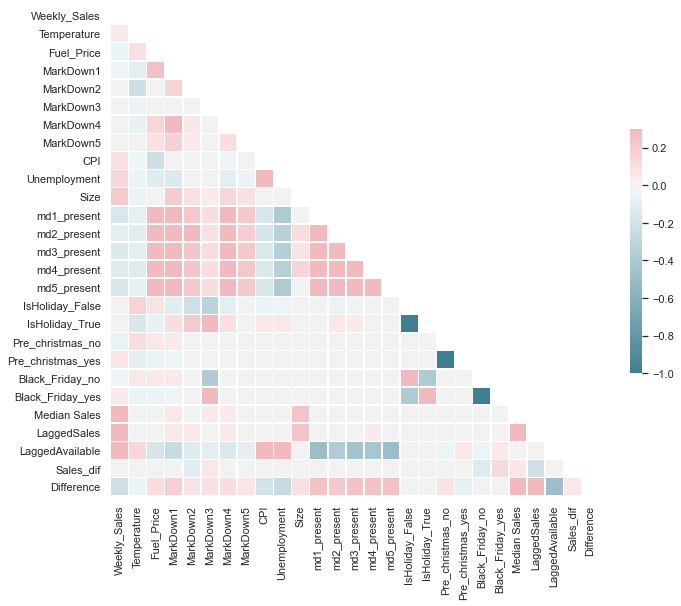

In [38]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
selector = [
    #'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment', 
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
count,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,5.366340e+05,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000
mean,159.852499,3.408310,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,136678.550960,14.873201,-1.083398e-12,0.928091,0.071909,0.988851,0.011149,0.988896,0.011104,15969.738804,-195.362035,0.773412
std,58.383773,0.430861,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,61007.711799,10.377064,1.000000e+00,0.258338,0.258338,0.104999,0.104999,0.104791,0.104791,22689.394444,6003.550792,0.418624
min,0.000000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,34875.000000,-21.827778,-2.689589e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1750.000000,-540263.085000,0.000000
25%,131.126667,3.041000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.000000,7.361111,-3.358481e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2102.872500,-302.140000,1.000000
50%,140.439786,3.523000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.000000,15.588889,1.223400e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7608.320000,0.000000,1.000000
75%,212.303441,3.744000,5046.740000,118.730000,29.140000,906.450000,2852.190000,202505.000000,22.905556,4.735060e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20182.661250,279.820000,1.000000
max,228.976456,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,219622.000000,38.861111,2.629182e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,693099.360000,579251.325000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,211.096358,2.572,0.0,0.0,0.0,0.0,0.0,151315,5.727778,0.322635,...,False,1,0,1,0,1,0,23510.49,0.00,0.0
1,211.289143,2.514,0.0,0.0,0.0,0.0,0.0,151315,4.405556,0.322635,...,False,1,0,1,0,1,0,46039.49,-22529.00,1.0
2,211.319643,2.561,0.0,0.0,0.0,0.0,0.0,151315,8.127778,0.322635,...,False,1,0,1,0,1,0,41595.55,-18085.06,1.0
3,212.566881,2.989,0.0,0.0,0.0,0.0,0.0,151315,5.705556,0.187371,...,False,1,0,1,0,1,0,18461.18,5049.31,1.0
4,213.247885,3.045,0.0,0.0,0.0,0.0,0.0,151315,14.088889,0.187371,...,False,1,0,1,0,1,0,37887.17,-14376.68,1.0


### 4. Train and Test the data

In [40]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
9,Store_1,Dept_1,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-01IsHoliday_False,2013-01-25,23510.49,0.0,0.0,23510.49
10,Store_1,Dept_1,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-15IsHoliday_False,2013-02-08,23510.49,0.0,0.0,23510.49
11,Store_1,Dept_1,2013-02-22,0.0,IsHoliday_False,10.138889,3.597,20107.75,3163.89,42.20,...,0,1,0,23510.49,Type_ADept_1Store_12013-02-22IsHoliday_False,2013-02-15,23510.49,0.0,0.0,23510.49
21,Store_1,Dept_2,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,0,1,0,47080.12,Type_ADept_2Store_12013-02-01IsHoliday_False,2013-01-25,47080.12,0.0,0.0,47080.12
22,Store_1,Dept_2,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,0,1,0,47080.12,Type_ADept_2Store_12013-02-15IsHoliday_False,2013-02-08,47080.12,0.0,0.0,47080.12


In [41]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(84314, 24)
(84314,)


### 5. Model Selection

#### 5.1 Adam optimizer with regularization

In [42]:
neural = False
if neural:
    # Sequential model
    
    adam_regularized = Sequential()

    # First hidden layer now regularized
    adam_regularized.add(Dense(32,activation='relu',
                    input_dim=X_train.shape[1],
                    kernel_regularizer = regularizers.l2(0.01)))

    # Second hidden layer now regularized
    adam_regularized.add(Dense(16,activation='relu',
                       kernel_regularizer = regularizers.l2(0.01)))

    # Output layer stayed sigmoid
    adam_regularized.add(Dense(1,activation='linear'))

    # Setup adam optimizer
    adam_optimizer=keras.optimizers.Adam(lr=0.01,
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-08)
    # Compile the model
    adam_regularized.compile(optimizer=adam_optimizer,
                  loss='mean_absolute_error',
                  metrics=['acc'])

    # Train
    history_adam_regularized=adam_regularized.fit(X_train, y_train, # Train on training set
                                 epochs=10, # We will train over 1,000 epochs
                                 batch_size=2048, # Batch size 
                                 verbose=0) # Suppress Keras output
    adam_regularized.evaluate(x=X_dev,y=y_dev)

    # Plot network
    plt.plot(history_adam_regularized.history['loss'], label='Adam Regularized')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    y_pred_neural = adam_regularized.predict(X_dev)

#### 5.2 Random Forest

In [43]:
#Random forest model specification
regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.2min finished


RandomForestRegressor(n_estimators=20, n_jobs=1, verbose=2)

### 6. Model Selection

In [44]:
y_pred_random = regr.predict(X_dev)

y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.1s finished


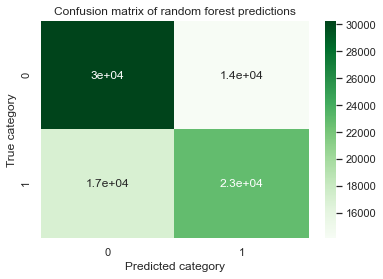

In [45]:
# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()

In [46]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.00,0.00,0.00,...,1,0,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,41595.55,1.0,-18085.06,4106.95,-4257.36525
7,Store_1,Dept_1,2012-02-17,54060.10,IsHoliday_False,7.400000,3.510,9873.33,11062.27,9.80,...,1,0,23510.49,Type_ADept_1Store_12012-02-17IsHoliday_False,2012-02-10,36988.49,1.0,-13478.00,-30549.61,-8893.01650
14,Store_1,Dept_2,2010-02-26,44292.87,IsHoliday_False,8.127778,2.561,0.00,0.00,0.00,...,1,0,47080.12,Type_ADept_2Store_12010-02-26IsHoliday_False,2010-02-19,47928.89,1.0,-848.77,2787.25,-198.70450
30,Store_1,Dept_3,2012-02-03,12485.78,IsHoliday_False,13.638889,3.360,34577.06,3579.21,160.53,...,1,0,11135.17,Type_ADept_3Store_12012-02-03IsHoliday_False,2012-01-27,10613.17,1.0,522.00,-1350.61,-165.95375
39,Store_1,Dept_4,2011-02-04,35870.49,IsHoliday_False,5.705556,2.989,0.00,0.00,0.00,...,1,0,36479.25,Type_ADept_4Store_12011-02-04IsHoliday_False,2011-01-28,32905.88,1.0,3573.37,608.76,294.30625


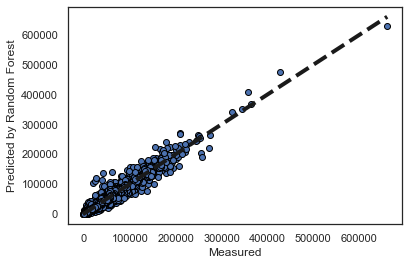

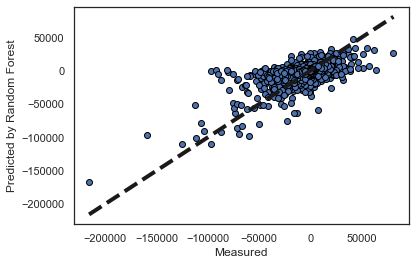

In [47]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")

In [48]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1540.236027231539
Random Forest: 1349.0571538771733


In [49]:
#Random forest model specification. Set n_estimators lower for faster performance
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

RandomForestRegressor(n_estimators=80, n_jobs=1)

### 7. Forecasting Sales

In [50]:
 final_y_prediction = rf_model.predict(test[selector])

In [51]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,Store_1,Dept_1,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,0,23510.49,Type_ADept_1Store_12013-02-01IsHoliday_False,2013-01-25,23510.49,0.0,0.0,23510.49,-3719.775375,27230.265375
1,Store_1,Dept_1,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,0,23510.49,Type_ADept_1Store_12013-02-15IsHoliday_False,2013-02-08,23510.49,0.0,0.0,23510.49,-3820.504313,27330.994313
2,Store_1,Dept_1,2013-02-22,0.0,IsHoliday_False,10.138889,3.597,20107.75,3163.89,42.20,...,0,23510.49,Type_ADept_1Store_12013-02-22IsHoliday_False,2013-02-15,23510.49,0.0,0.0,23510.49,-3660.545750,27171.035750
3,Store_1,Dept_2,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,0,47080.12,Type_ADept_2Store_12013-02-01IsHoliday_False,2013-01-25,47080.12,0.0,0.0,47080.12,-6409.767750,53489.887750
4,Store_1,Dept_2,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,0,47080.12,Type_ADept_2Store_12013-02-15IsHoliday_False,2013-02-08,47080.12,0.0,0.0,47080.12,-5792.879938,52872.999938


In [52]:
submission = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['prediction']})
submission.head()

,id,Weekly_Sales
0,1_1_2013-02-01,27230.265375
1,1_1_2013-02-15,27330.994313
2,1_1_2013-02-22,27171.035750
3,1_2_2013-02-01,53489.887750
4,1_2_2013-02-15,52872.999938


In [53]:
submission.to_csv('submission.csv',index=False)